In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

PROJECT_ROOT = "/content/drive/MyDrive/fish_attention_HydraViT_test"
sys.path.insert(0, PROJECT_ROOT)


# pip timm 캐시 완전 제거
for k in list(sys.modules.keys()):
    if k == "timm" or k.startswith("timm."):
        del sys.modules[k]

In [ ]:
import timm
print("timm module path:", getattr(timm, "__file__", None))
print("timm package paths:", list(getattr(timm, "__path__", [])))

timm module path: /content/drive/MyDrive/fish_attention_HydraViT_test/timm/__init__.py
timm package paths: ['/content/drive/MyDrive/fish_attention_HydraViT_test/timm']


In [ ]:
from timm.models.hydravit import HydraViT, FiSHBlock, Block

In [ ]:
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
from timm.data import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD

def get_dataloaders(data_dir: str, batch_size: int, num_workers: int):
    transform_train = T.Compose([
        T.Resize(256),
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD),
    ])

    transform_test = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD),
    ])

    train_set = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train,
    )
    test_set = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_test,
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [ ]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from functools import partial

# --- p sweep
P_VALUES = [64, 192, 320, 448, 576]
HEAD_DIM = 64

DIM_MAX = 576
NUM_HEADS_MAX = DIM_MAX // HEAD_DIM  # 9

DEPTH = 8
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 10

LR = 3e-4
EPOCHS = 5


In [ ]:
def create_baseline_hydravit(device):
    model = HydraViT(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        in_chans=3,
        num_classes=NUM_CLASSES,
        embed_dim=DIM_MAX,
        depth=DEPTH,
        num_heads=NUM_HEADS_MAX,
        block_fn=Block,
    )
    return model.to(device)

def create_fish_hydravit(device, K_global=9):
    fish_block = partial(
        FiSHBlock,
        num_global_heads=K_global,   # global head 최대치
        fish_stochastic=False,
        fish_hard=False,
        fish_tau=1.0,
    )
    model = HydraViT(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        in_chans=3,
        num_classes=NUM_CLASSES,
        embed_dim=DIM_MAX,
        depth=DEPTH,
        num_heads=NUM_HEADS_MAX,
        block_fn=fish_block,         # partial 주입
    )
    return model.to(device)

In [ ]:
def _cuda_sync(device):
    if device.type == "cuda":
        torch.cuda.synchronize()

class TempSetP:
    def __init__(self, model, p: int):
        self.model = model
        self.p = p
        self.old_p = None

    def __enter__(self):
        self.old_p = getattr(self.model, "p", None)
        self.model.p = self.p
        return self.model

    def __exit__(self, exc_type, exc, tb):
        if self.old_p is not None:
            self.model.p = self.old_p

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, p_train: int):
    model.train()
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with TempSetP(model, p_train):
            out = model(x)

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return correct / max(1, total)

@torch.no_grad()
def test_acc(model, loader, device, p_eval: int):
    model.eval()
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with TempSetP(model, p_eval):
            out = model(x)

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return correct / max(1, total)

In [ ]:
def run_experiment(model_name: str, model, train_loader, test_loader, device, p_train: int = 576):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # epoch별 test_acc 로그
    epoch_logs = {p: [] for p in P_VALUES}

    for ep in range(1, EPOCHS + 1):
        print(f"[{model_name}] START epoch {ep}/{EPOCHS}", flush=True)

        _cuda_sync(device)
        t0 = time.time()

        tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, p_train=p_train)

        _cuda_sync(device)
        t1 = time.time()

        # p sweep test
        test_line = []
        for p in P_VALUES:
            acc = test_acc(model, test_loader, device, p_eval=p)
            epoch_logs[p].append(float(acc))
            test_line.append(f"p={p}:{acc:.4f}")

        print(
            f"[{model_name}][epoch {ep}/{EPOCHS}] "
            f"train(p={p_train})={tr_acc:.4f} | "
            f"train_time={(t1-t0)/60:.2f} min | "
            f"test: " + " | ".join(test_line),
            flush=True
        )
        sys.stdout.flush()

    # 최종 test_acc(p별)
    final_test = {p: float(test_acc(model, test_loader, device, p_eval=p)) for p in P_VALUES}

    print(f"\n[{model_name}] Final Test Accuracy (full test set)")
    for p in P_VALUES:
        print(f"  p={p:3d} (H={p//64}): {final_test[p]:.4f}")
    print("", flush=True)

    return epoch_logs, final_test

In [ ]:
def plot_per_p(baseline_epoch_logs, fish_epoch_logs):
    for p in P_VALUES:
        yb = baseline_epoch_logs[p]
        yf = fish_epoch_logs[p]

        n = min(len(yb), len(yf))
        if n == 0:
            print(f"[plot] skip p={p} because no data")
            continue

        xs = list(range(1, n + 1))

        plt.figure(figsize=(6.5, 4.2))
        plt.plot(xs, yb[:n], linestyle="--", marker="o", label=f"baseline (p={p}, H={p//64})")
        plt.plot(xs, yf[:n], linestyle="-",  marker="o", label=f"fish (p={p}, H={p//64})")

        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.title(f"Epoch-wise Test Accuracy (p={p}, H={p//64})")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_final_summary(baseline_final_test, fish_final_test):
    xs = P_VALUES
    yb = [baseline_final_test[p] for p in xs]
    yf = [fish_final_test[p] for p in xs]

    plt.figure(figsize=(7.2, 4.6))
    plt.plot(xs, yb, linestyle="--", marker="o", label="baseline (final test_acc)")
    plt.plot(xs, yf, linestyle="-",  marker="o", label="fish (final test_acc)")
    plt.xlabel("p (subnet width)")
    plt.ylabel("Final Test Accuracy")
    plt.title("Final Test Accuracy by p (Baseline vs FiSH)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.xticks(xs, [str(p) for p in xs])

    plt.tight_layout()
    plt.show()

def plot_epoch_by_p(epoch_logs, model_name: str = "baseline"):
    lens = [len(epoch_logs[p]) for p in P_VALUES if p in epoch_logs]
    if len(lens) == 0 or min(lens) == 0:
        print(f"[plot_epoch_by_p] skip: no data for {model_name}")
        return

    n = min(lens)  # 공통 epoch 수
    xs = list(range(1, n + 1))

    plt.figure(figsize=(7.6, 4.8))
    for p in P_VALUES:
        ys = epoch_logs[p][:n]
        plt.plot(xs, ys, marker="o", label=f"p={p} (H={p//64})")

    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title(f"Epoch-wise Test Accuracy by p ({model_name})")
    plt.grid(True, alpha=0.3)

    plt.xticks(xs)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = get_dataloaders(
    data_dir="/content/data",
    batch_size=64,
    num_workers=2,
)

print("device:", device)
print("P_VALUES:", P_VALUES, "=> heads:", [p//64 for p in P_VALUES])
print("DIM_MAX:", DIM_MAX, "NUM_HEADS_MAX:", NUM_HEADS_MAX)

# ---- baseline ----
baseline_model = create_baseline_hydravit(device)
baseline_epoch_logs, baseline_final_test = run_experiment(
    "baseline", baseline_model, train_loader, test_loader, device, p_train=max(P_VALUES)
)
del baseline_model
torch.cuda.empty_cache()

# ---- fish ----
fish_model = create_fish_hydravit(device, K_global=NUM_HEADS_MAX)  # 9 권장
fish_epoch_logs, fish_final_test = run_experiment(
    "fish", fish_model, train_loader, test_loader, device, p_train=max(P_VALUES)
)
del fish_model
torch.cuda.empty_cache()

# sanity check
print("baseline lens:", {p: len(baseline_epoch_logs[p]) for p in P_VALUES})
print("fish lens:", {p: len(fish_epoch_logs[p]) for p in P_VALUES})

device: cuda
P_VALUES: [64, 192, 320, 448, 576] => heads: [1, 3, 5, 7, 9]
DIM_MAX: 576 NUM_HEADS_MAX: 9
[baseline] START epoch 1/5
[baseline][epoch 1/5] train(p=576)=0.2577 | train_time=12.28 min | test: p=64:0.1226 | p=192:0.1618 | p=320:0.2773 | p=448:0.3410 | p=576:0.3518
[baseline] START epoch 2/5
[baseline][epoch 2/5] train(p=576)=0.3550 | train_time=12.37 min | test: p=64:0.1413 | p=192:0.1844 | p=320:0.2344 | p=448:0.3930 | p=576:0.4198
[baseline] START epoch 3/5
[baseline][epoch 3/5] train(p=576)=0.3982 | train_time=12.40 min | test: p=64:0.1480 | p=192:0.1933 | p=320:0.2304 | p=448:0.3680 | p=576:0.4297
[baseline] START epoch 4/5
[baseline][epoch 4/5] train(p=576)=0.4146 | train_time=12.40 min | test: p=64:0.1452 | p=192:0.1916 | p=320:0.2209 | p=448:0.3938 | p=576:0.4767
[baseline] START epoch 5/5
[baseline][epoch 5/5] train(p=576)=0.4368 | train_time=12.42 min | test: p=64:0.1369 | p=192:0.1995 | p=320:0.2128 | p=448:0.4299 | p=576:0.4641

[baseline] Final Test Accuracy (ful

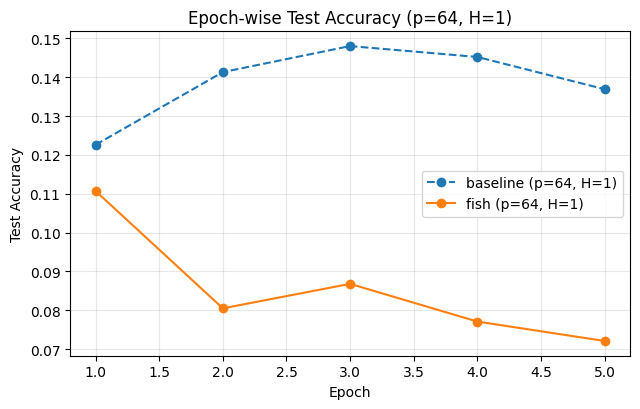

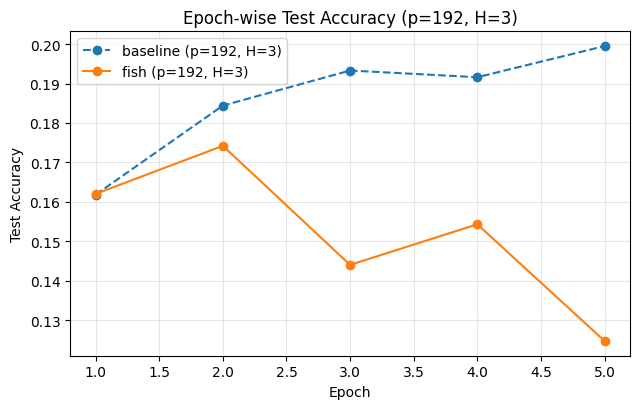

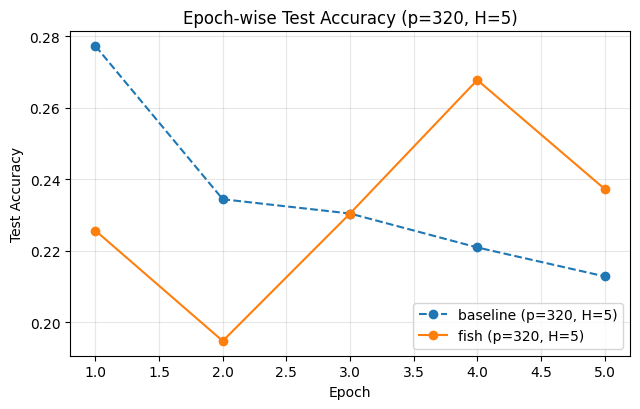

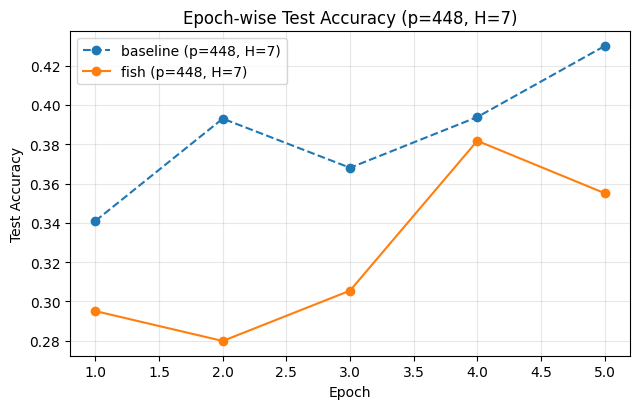

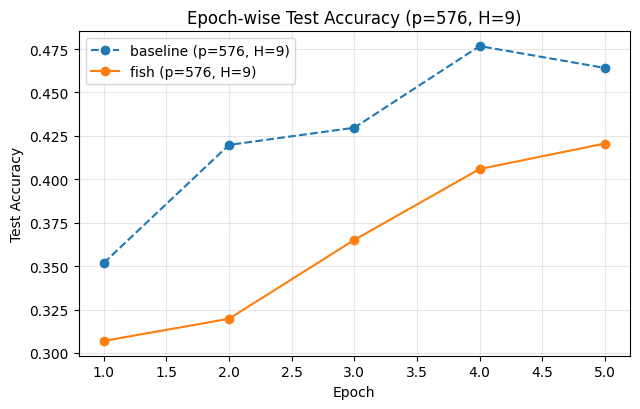

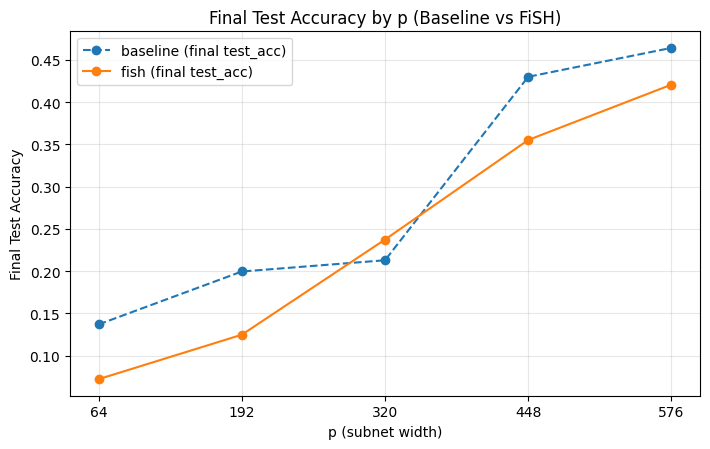

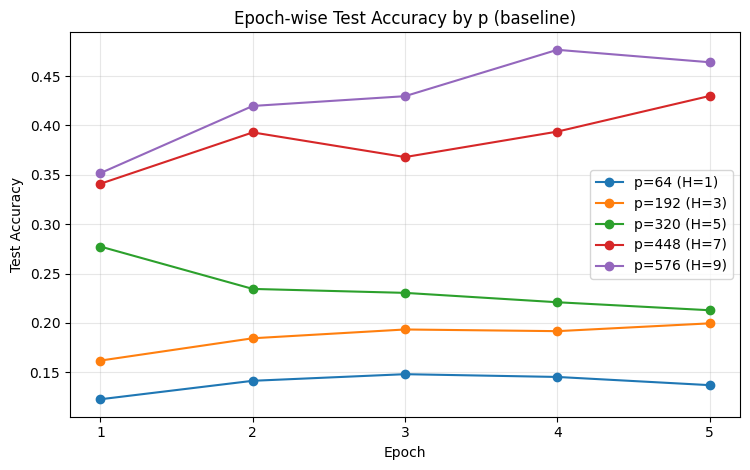

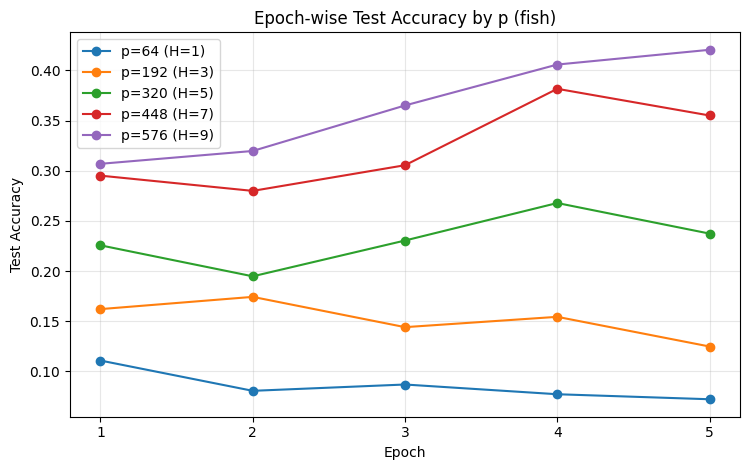

In [ ]:
# ---- plots ----
plot_per_p(baseline_epoch_logs, fish_epoch_logs)
plot_final_summary(baseline_final_test, fish_final_test)

plot_epoch_by_p(baseline_epoch_logs, model_name="baseline")
plot_epoch_by_p(fish_epoch_logs, model_name="fish")